{
    "2CB": [
        6,
        8
    ],
    "3CB": [
        6,
        8,
        13
    ],
    "4CB": [
        1,
        6,
        8,
        13
    ],
    "7CB": [
        1,
        6,
        7,
        8,
        13,
        14,
        17
    ],
    "2CW": [
        0,
        2
    ],
    "3CW": [
        0,
        2,
        5
    ],
    "4CW": [
        13,
        15,
        16,
        17
    ],
    "7CW": [
        11,
        12,
        13,
        14,
        15,
        16,
        17
    ]
}

In [1]:
import sys
sys.path.append('../src')
from utils import *
from networks_debug import *
from dataloader import WisdmDatasetParser, WisdmDataset
from torch.utils.data import  DataLoader
from pathlib import Path
from tqdm import tqdm

In [2]:
import itertools
import numpy as np
from scipy.stats import entropy
from sklearn.metrics import mean_squared_error

def calculate_separability_scores_v2(distance_matrix, num_classes, n):
    class_combinations = itertools.combinations(range(num_classes), n)
    separability_scores = []
    print("Calculating final separability scores...")
    for combination in tqdm(class_combinations, desc="Combinations"):
        distances = distance_matrix[np.ix_(combination, combination)]
        median_distance = np.median(distances.flatten())
        
        # Calculate the distances distribution
        distances_distribution = distances.flatten()
        distances_distribution /= np.sum(distances_distribution)  # Normalize the distribution
        
        # Calculate the uniform distribution
        uniform_distribution = np.full_like(distances_distribution, 1 / len(distances_distribution))
        
        # Calculate the mse between the distributions 
        mse = mean_squared_error(distances_distribution, uniform_distribution)
        score = calculate_separability_score(combination, distance_matrix)
        separability_scores.append((combination, score, median_distance, mse))
    
    separability_scores.sort(key=lambda x: x[1], reverse=True)
    
    top_combinations = separability_scores[:10]
    for comb, score, median_dist, mse in top_combinations:
        print(f"Combination: {comb}, Score: {score}, Median Distance: {median_dist}, mse: {mse}")
    
    return separability_scores

def search_combination(separability_scores, combination):
    for comb, score, median_dist, mse in separability_scores:
        if comb == combination:
            print(f"Combination: {comb}, Score: {score}, Median Distance: {median_dist}, mse: {mse}")
            break
    else:
        print("Combination not found in separability scores.")

In [3]:


dataset = WisdmDatasetParser(f'{Path.home()}/snntorch_network/data/data_watch_subset_0_40.npz', norm=None)
train_set = dataset.get_training_set()

data, labels = train_set 
num_classes = 18
#distance_matrix_subset_0 =calculate_distance_matrix(data, labels, num_classes, show_matrix=True, save_matrix_name="wisdm_subset_0_40")


(6,)
(6,)
ytrain shape (55404, 18)
yval shape (18468, 18)
ytest shape (18469, 18)
num classes train dataset: 18 occurrences of each class:[3127 3066 2855 3205 3044 3092 3102 2981 3047 3150 3087 3058 3154 3095
 2973 3013 3142 3213]
num classes eval dataset: 18 occurrences of each class:[1035  968  935 1024 1048 1038 1122  982  996 1110 1053 1039 1066  966
 1007  979 1023 1077]
num classes test dataset: 18 occurrences of each class:[1046 1061  900 1045 1048 1029 1046  989 1036 1076 1026 1067 1014  965
  982 1049 1036 1054]


In [4]:
dataset = WisdmDatasetParser(f'{Path.home()}/snntorch_network/data/wisdm_watch_full_40.npz', norm=None)
train_set = dataset.get_training_set()

data, labels = train_set 

#distance_matrix_full =calculate_distance_matrix(data, labels, num_classes, show_matrix=True, save_matrix_name="wisdm_watch_full_40")


(6,)
(6,)
ytrain shape (110807, 18)
yval shape (36936, 18)
ytest shape (36936, 18)
num classes train dataset: 18 occurrences of each class:[6299 6119 5674 6286 6232 6164 6287 5934 6155 6340 6181 6163 6282 6038
 5984 6024 6176 6469]
num classes eval dataset: 18 occurrences of each class:[2115 2058 1846 2103 2018 2069 2072 1985 1945 2193 2044 2089 2090 2014
 2010 2014 2107 2164]
num classes test dataset: 18 occurrences of each class:[2008 2012 1856 2157 2031 2080 2182 1987 2056 2135 2109 2077 2092 2000
 1937 2046 2115 2056]


In [5]:
distance_matrix_subset_0 = np.load("distance_matrix_wisdm_subset_0_40.npy")
distance_matrix_full = np.load("distance_matrix_wisdm_watch_full_40.npy")

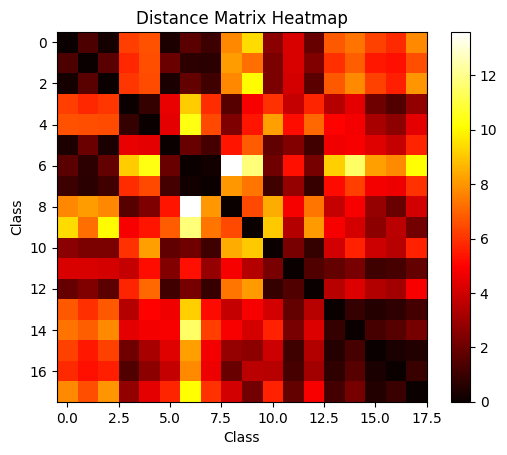

array([[ 0.        ,  1.36626256,  0.22674977,  6.2540834 ,  6.60355935,
         0.4126142 ,  1.67392856,  1.04737584,  7.743277  ,  9.43939964,
         2.60859897,  4.22801584,  1.85814319,  6.74511709,  7.29322331,
         6.29468019,  5.78750072,  7.78956134],
       [ 1.36626256,  0.        ,  1.64334538,  5.76972829,  6.54571581,
         2.00777363,  0.71677381,  0.65018367,  8.14387195,  7.20372713,
         2.33465271,  4.19680193,  2.41684187,  5.89603582,  6.85621409,
         5.45142538,  5.29064864,  6.5687139 ],
       [ 0.22674977,  1.64334538,  0.        ,  6.08593035,  6.50854183,
         0.36244207,  1.83611346,  1.09827497,  7.74155186, 10.06420277,
         2.30475693,  4.11469705,  1.67543903,  6.75918329,  7.7802169 ,
         6.29857166,  5.62644228,  7.98088634],
       [ 6.2540834 ,  5.76972829,  6.08593035,  0.        ,  0.860733  ,
         4.52872787,  9.11297136,  5.86530299,  1.5842731 ,  4.84393697,
         5.95590631,  3.82157332,  5.68260293,  3.481

In [6]:
distance_matrix_subset(distance_matrix_full, [i for i in range(18)])

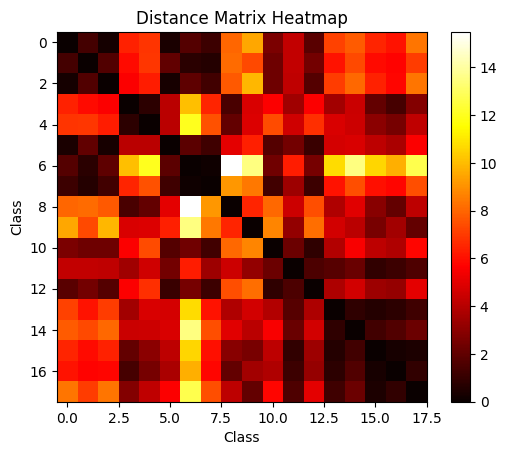

array([[ 0.        ,  1.35798804,  0.24356781,  6.43987169,  6.88752128,
         0.37923996,  1.75070364,  1.15559698,  8.02097049,  9.5354647 ,
         2.62961164,  4.28879564,  1.87180846,  7.18937626,  7.78263924,
         6.49939387,  6.06016937,  8.3513537 ],
       [ 1.35798804,  0.        ,  1.666387  ,  5.89985969,  6.8965009 ,
         2.00398734,  0.75244943,  0.65515476,  8.11237075,  7.36183336,
         2.31177806,  4.25289078,  2.44544536,  6.09393964,  7.34342624,
         5.88342919,  5.73829933,  7.05150863],
       [ 0.24356781,  1.666387  ,  0.        ,  5.59471118,  6.29231138,
         0.3278962 ,  1.99105941,  1.30654561,  7.70244182,  9.89186059,
         2.32867298,  4.19174679,  1.69722184,  7.03653686,  8.07513238,
         6.43320111,  5.7615195 ,  8.37773386],
       [ 6.43987169,  5.89985969,  5.59471118,  0.        ,  0.84415148,
         4.06092342, 10.04019379,  6.51579011,  1.45148944,  4.80129867,
         5.61978041,  3.47184142,  5.57306892,  3.519

In [7]:
distance_matrix_subset(distance_matrix_subset_0, [i for i in range(18)])

In [8]:
separability_scores = calculate_separability_scores_v2(distance_matrix_subset_0, num_classes, 7)
search_combination(separability_scores, (0, 1, 2, 3, 4, 5, 6))

Calculating final separability scores...


Combinations: 31824it [00:08, 3773.46it/s]

Combination: (0, 2, 6, 8, 9, 14, 17), Score: 150.93521362323165, Median Distance: 6.523463992617017, mse: 0.00023801246090443345
Combination: (0, 4, 6, 8, 9, 10, 14), Score: 150.29896282779436, Median Distance: 5.520185704220147, mse: 0.0002099849645891684
Combination: (2, 4, 6, 8, 9, 10, 14), Score: 149.97353040704218, Median Distance: 5.520185704220147, mse: 0.00021185211137153662
Combination: (0, 2, 4, 6, 8, 9, 14), Score: 149.74290149419437, Median Distance: 6.292311378763229, mse: 0.0002267251328386723
Combination: (2, 4, 6, 7, 8, 9, 14), Score: 149.61196399839844, Median Distance: 6.292311378763229, mse: 0.00022926310993227235
Combination: (0, 4, 6, 7, 8, 9, 14), Score: 149.4855091266457, Median Distance: 6.523463992617017, mse: 0.00023036524132757216
Combination: (2, 4, 6, 8, 9, 14, 17), Score: 149.2628153141958, Median Distance: 4.893550762854715, mse: 0.00023519576389758356
Combination: (0, 4, 6, 8, 9, 14, 17), Score: 149.2609289218063, Median Distance: 4.893550762854715, mse:

In [9]:
separability_scores.sort(key=lambda x: x[3])
print(separability_scores[:10])
print(len(separability_scores))

[((4, 5, 8, 9, 11, 14, 17), 84.14278595996294, 4.05779949780174, 0.0001286174802682606), ((4, 5, 8, 9, 11, 13, 14), 84.84301367055771, 4.05779949780174, 0.00012911372311236934), ((3, 4, 5, 8, 9, 11, 14), 83.34156533121296, 4.05779949780174, 0.00013335128853777338), ((1, 4, 5, 8, 9, 13, 14), 103.90583313448917, 4.675655121166208, 0.00013346785811675922), ((3, 4, 5, 9, 11, 13, 14), 78.98815624365551, 4.0556115285914425, 0.00013483582147572173), ((1, 4, 5, 8, 9, 14, 17), 104.32880457329375, 4.49628592910835, 0.00013509338002006384), ((4, 5, 8, 9, 13, 14, 17), 85.5835661561429, 4.131277092963123, 0.00013566661338894613), ((1, 4, 5, 8, 9, 11, 14), 100.22447979065295, 4.49628592910835, 0.00013569592725953778), ((1, 4, 5, 8, 9, 11, 13), 98.13131058143665, 4.5238598577665075, 0.00013602701485668743), ((3, 4, 5, 9, 11, 14, 17), 77.29393325922987, 3.471841418286927, 0.00013631596572501038)]
31824


In [10]:
filtered_scores = [x for x in separability_scores if x[3] < 0.00015 and x[1] > 125]
filtered_scores.sort(key=lambda x: x[1], reverse=True)
filtered_scores

[((0, 1, 4, 8, 9, 10, 14),
  125.05112143473804,
  5.520185704220147,
  0.00014356131076266704)]

In [11]:
search_combination(separability_scores, (0, 2, 6, 8, 9, 14, 17))

Combination: (0, 2, 6, 8, 9, 14, 17), Score: 150.93521362323165, Median Distance: 6.523463992617017, mse: 0.00023801246090443345


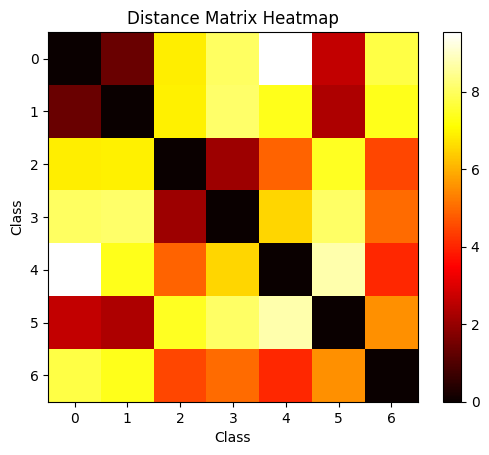

Combination: (0, 1, 4, 8, 9, 10, 14), Score: 125.05112143473804, Median Distance: 5.520185704220147, mse: 0.00014356131076266704


In [12]:
# filtered_scores = [x for x in separability_scores if x[3] < 0.00015 and x[1] > 125]
# filtered_scores.sort(key=lambda x: x[1], reverse=True)
# # filtered_scores
# [((0, 1, 4, 8, 9, 10, 14),
#   125.05112143473804,
#   5.520185704220147,
#   0.00014356131076266704)]

distance_matrix_subset(distance_matrix_subset_0, [0, 1, 4, 8, 9, 10, 14])
search_combination(separability_scores, (0, 1, 4, 8, 9, 10, 14))

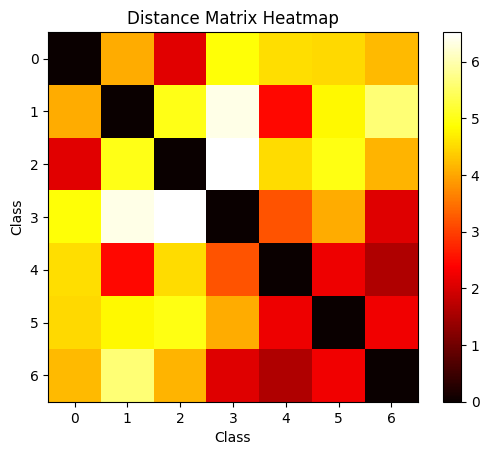

Combination: (4, 5, 8, 9, 11, 14, 17), Score: 84.14278595996294, Median Distance: 4.05779949780174, mse: 0.0001286174802682606


In [13]:

#Migliore mse
distance_matrix_subset(distance_matrix_subset_0, [4, 5, 8, 9, 11, 14, 17])
search_combination(separability_scores, (4, 5, 8, 9, 11, 14, 17))

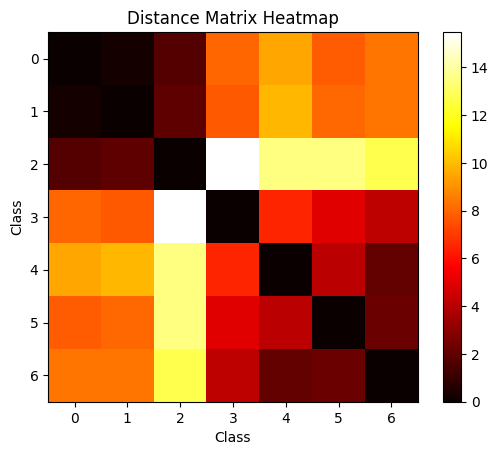

Combination: (0, 2, 6, 8, 9, 14, 17), Score: 150.93521362323165, Median Distance: 6.523463992617017, mse: 0.00023801246090443345


In [14]:
#Migliore combinazione in assoluto
distance_matrix_subset(distance_matrix_subset_0, [0, 2, 6, 8, 9, 14, 17])
search_combination(separability_scores, (0, 2, 6, 8, 9, 14, 17))

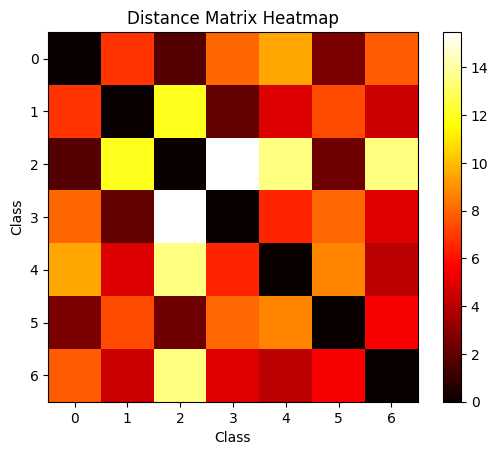

Combination: (0, 4, 6, 8, 9, 10, 14), Score: 150.29896282779436, Median Distance: 5.520185704220147, mse: 0.0002099849645891684


In [15]:
#seconda miglior combinazione
distance_matrix_subset(distance_matrix_subset_0, [0, 4, 6, 8, 9, 10, 14])
search_combination(separability_scores, (0, 4, 6, 8, 9, 10, 14))

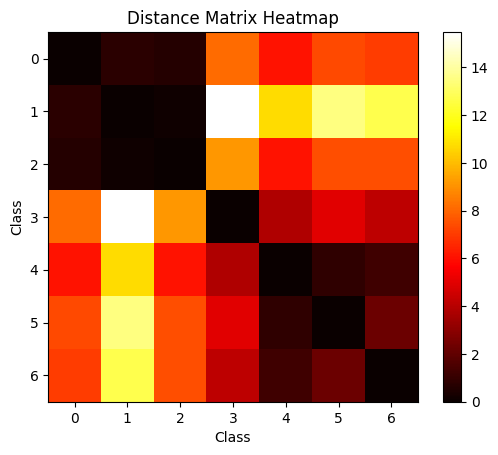

Combination: (1, 6, 7, 8, 13, 14, 17), Score: 130.06819959923016, Median Distance: 4.994155625360855, mse: 0.0003086062940677365


In [16]:
#combinazione migliore di Marco
distance_matrix_subset(distance_matrix_subset_0, [1, 6, 7, 8, 13, 14, 17])
search_combination(separability_scores, (1, 6, 7, 8, 13, 14, 17))

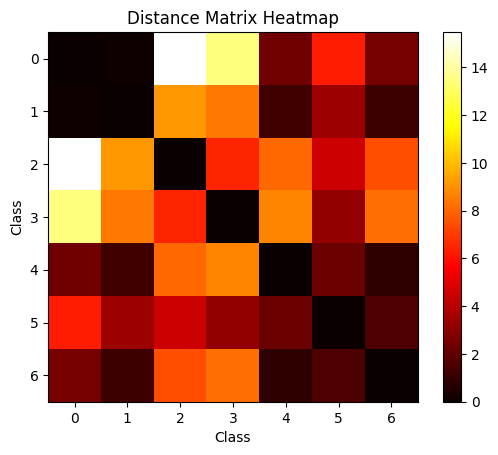

Combination: (6, 7, 8, 9, 10, 11, 12), Score: 115.19648011618727, Median Distance: 3.190976689136687, mse: 0.000344279475374927


In [17]:
#subset 2 
distance_matrix_subset(distance_matrix_subset_0, [6, 7, 8, 9, 10, 11, 12])
search_combination(separability_scores, (6, 7, 8, 9, 10, 11, 12))

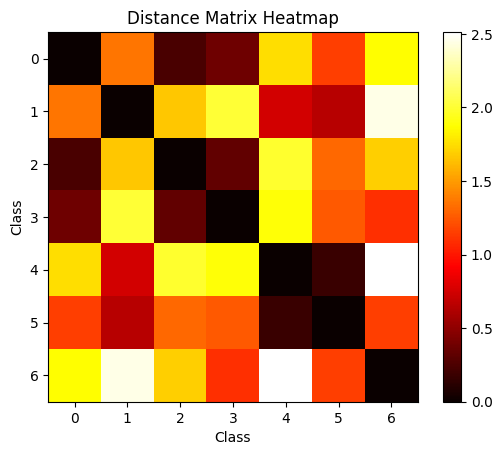

Combination: (0, 1, 2, 5, 6, 7, 12), Score: 27.679646665441144, Median Distance: 1.155596978787619, mse: 0.00020110201313216223


In [18]:
#Combianazione peggiore in assoluto 
distance_matrix_subset(distance_matrix_subset_0, [0, 1, 2, 5, 6, 7, 12])
search_combination(separability_scores, (0, 1, 2, 5, 6, 7, 12))

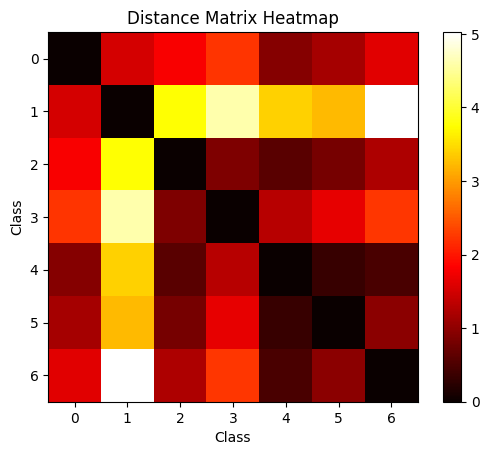

Combination: (11, 12, 13, 14, 15, 16, 17), Score: 39.77028514026115, Median Distance: 1.221902128345484, mse: 0.00030563372638710523


In [19]:
#combinazione peggiore di Marco
distance_matrix_subset(distance_matrix_subset_0, [11, 12, 13, 14, 15, 16, 17])
search_combination(separability_scores, (11, 12, 13, 14, 15, 16, 17))

In [20]:
def standardize_scores_range(separability_scores):
    score_sum = [x[1] for x in separability_scores]
    score_mse = [x[3] for x in separability_scores]
    separability_tmp = [list(x) for x in separability_scores]
    sum_max = max(score_sum)
    sum_min = min(score_sum)
    mse_max = max(score_mse)
    mse_min = min(score_mse)
    for i in range(len(separability_tmp)):
        sum_norm = (separability_tmp[i][1] - sum_min) / (sum_max - sum_min)
        mse_norm = (separability_tmp[i][3] - mse_min) / (mse_max - mse_min)
        separability_tmp[i][1] = sum_norm
        separability_tmp[i][3] = mse_norm
    return separability_tmp

In [21]:
normalized_separability_scores = standardize_scores_range(separability_scores)
normalized_separability_scores.sort(key=lambda x: x[1]-x[3]*1, reverse=True)
print(normalized_separability_scores[:3])
search_combination(separability_scores, normalized_separability_scores[0][0])
search_combination(separability_scores, normalized_separability_scores[1][0])
search_combination(separability_scores, normalized_separability_scores[2][0])


[[(0, 4, 6, 8, 9, 10, 14), 0.994837954900202, 5.520185704220147, 0.13240267810345902], [(2, 4, 6, 8, 9, 10, 14), 0.9921976488370801, 5.520185704220147, 0.13544093394313583], [(0, 2, 4, 6, 8, 9, 14), 0.990326504851131, 6.292311378763229, 0.15964259004906264]]
Combination: (0, 4, 6, 8, 9, 10, 14), Score: 150.29896282779436, Median Distance: 5.520185704220147, mse: 0.0002099849645891684
Combination: (2, 4, 6, 8, 9, 10, 14), Score: 149.97353040704218, Median Distance: 5.520185704220147, mse: 0.00021185211137153662
Combination: (0, 2, 4, 6, 8, 9, 14), Score: 149.74290149419437, Median Distance: 6.292311378763229, mse: 0.0002267251328386723


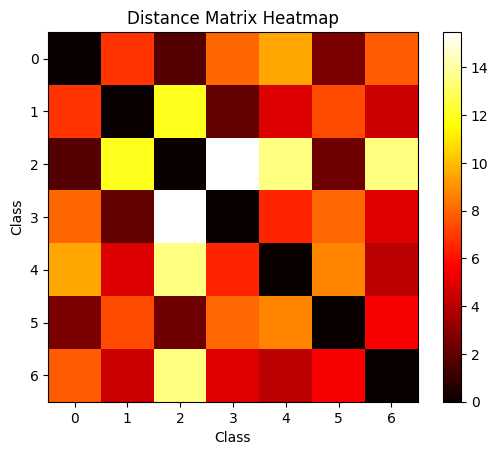

array([[ 0.        ,  6.88752128,  1.75070364,  8.02097049,  9.5354647 ,
         2.62961164,  7.78263924],
       [ 6.88752128,  0.        , 12.02037202,  2.10725598,  4.89355076,
         7.42719495,  4.49628593],
       [ 1.75070364, 12.02037202,  0.        , 15.4736105 , 13.50318827,
         2.38213019, 13.50173411],
       [ 8.02097049,  2.10725598, 15.4736105 ,  0.        ,  6.52346399,
         8.06055028,  4.99415563],
       [ 9.5354647 ,  4.89355076, 13.50318827,  6.52346399,  0.        ,
         8.73276198,  4.05561153],
       [ 2.62961164,  7.42719495,  2.38213019,  8.06055028,  8.73276198,
         0.        ,  5.5201857 ],
       [ 7.78263924,  4.49628593, 13.50173411,  4.99415563,  4.05561153,
         5.5201857 ,  0.        ]])

In [22]:
distance_matrix_subset(distance_matrix_subset_0, [0, 4, 6, 8, 9, 10, 14])

In [23]:
normalized_separability_scores.sort(key=lambda x: x[1]-x[3]*2, reverse=True)
print(normalized_separability_scores[:3])
search_combination(separability_scores, normalized_separability_scores[0][0])
search_combination(separability_scores, normalized_separability_scores[1][0])
search_combination(separability_scores, normalized_separability_scores[2][0])



[[(0, 1, 4, 8, 9, 10, 14), 0.7899965670730495, 5.520185704220147, 0.024316877867086008], [(1, 2, 4, 8, 9, 10, 14), 0.7879083105902298, 5.520185704220147, 0.026107105749007316], [(0, 4, 6, 8, 9, 10, 14), 0.994837954900202, 5.520185704220147, 0.13240267810345902]]
Combination: (0, 1, 4, 8, 9, 10, 14), Score: 125.05112143473804, Median Distance: 5.520185704220147, mse: 0.00014356131076266704
Combination: (1, 2, 4, 8, 9, 10, 14), Score: 124.79373219799481, Median Distance: 5.520185704220147, mse: 0.00014466148744488838
Combination: (0, 4, 6, 8, 9, 10, 14), Score: 150.29896282779436, Median Distance: 5.520185704220147, mse: 0.0002099849645891684


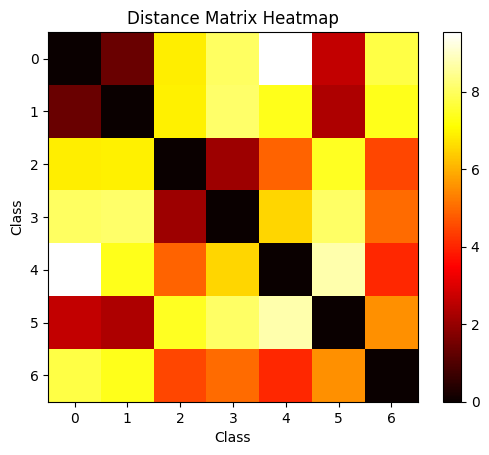

array([[0.        , 1.35798804, 6.88752128, 8.02097049, 9.5354647 ,
        2.62961164, 7.78263924],
       [1.35798804, 0.        , 6.8965009 , 8.11237075, 7.36183336,
        2.31177806, 7.34342624],
       [6.88752128, 6.8965009 , 0.        , 2.10725598, 4.89355076,
        7.42719495, 4.49628593],
       [8.02097049, 8.11237075, 2.10725598, 0.        , 6.52346399,
        8.06055028, 4.99415563],
       [9.5354647 , 7.36183336, 4.89355076, 6.52346399, 0.        ,
        8.73276198, 4.05561153],
       [2.62961164, 2.31177806, 7.42719495, 8.06055028, 8.73276198,
        0.        , 5.5201857 ],
       [7.78263924, 7.34342624, 4.49628593, 4.99415563, 4.05561153,
        5.5201857 , 0.        ]])

In [24]:
distance_matrix_subset(distance_matrix_subset_0, [0, 1, 4, 8, 9, 10, 14])

In [25]:
normalized_separability_scores.sort(key=lambda x: x[1]-x[3]*10, reverse=True)
print(normalized_separability_scores[:3])
search_combination(separability_scores, normalized_separability_scores[0][0])
search_combination(separability_scores, normalized_separability_scores[1][0])
search_combination(separability_scores, normalized_separability_scores[2][0])


[[(0, 1, 4, 8, 9, 10, 14), 0.7899965670730495, 5.520185704220147, 0.024316877867086008], [(1, 4, 5, 8, 9, 13, 14), 0.6184401106617121, 4.675655121166208, 0.00789262470524597], [(1, 4, 8, 9, 12, 14, 17), 0.6758289323266947, 4.598008189582699, 0.014744003027194115]]
Combination: (0, 1, 4, 8, 9, 10, 14), Score: 125.05112143473804, Median Distance: 5.520185704220147, mse: 0.00014356131076266704
Combination: (1, 4, 5, 8, 9, 13, 14), Score: 103.90583313448917, Median Distance: 4.675655121166208, mse: 0.00013346785811675922
Combination: (1, 4, 8, 9, 12, 14, 17), Score: 110.97932488584613, Median Distance: 4.598008189582699, mse: 0.00013767834257351704


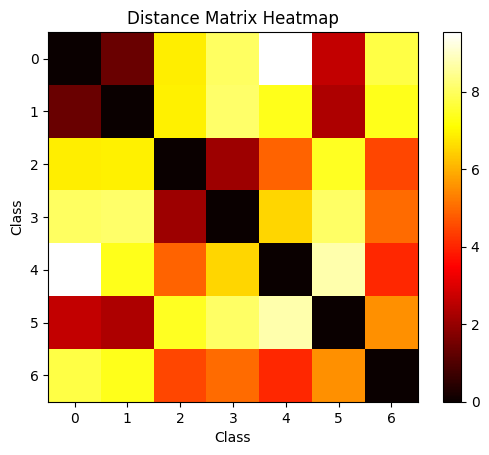

array([[0.        , 1.35798804, 6.88752128, 8.02097049, 9.5354647 ,
        2.62961164, 7.78263924],
       [1.35798804, 0.        , 6.8965009 , 8.11237075, 7.36183336,
        2.31177806, 7.34342624],
       [6.88752128, 6.8965009 , 0.        , 2.10725598, 4.89355076,
        7.42719495, 4.49628593],
       [8.02097049, 8.11237075, 2.10725598, 0.        , 6.52346399,
        8.06055028, 4.99415563],
       [9.5354647 , 7.36183336, 4.89355076, 6.52346399, 0.        ,
        8.73276198, 4.05561153],
       [2.62961164, 2.31177806, 7.42719495, 8.06055028, 8.73276198,
        0.        , 5.5201857 ],
       [7.78263924, 7.34342624, 4.49628593, 4.99415563, 4.05561153,
        5.5201857 , 0.        ]])

In [26]:
distance_matrix_subset(distance_matrix_subset_0, [0, 1, 4, 8, 9, 10, 14])

In [27]:
normalized_separability_scores.sort(key=lambda x: -x[1]+x[3], reverse=True)
print(normalized_separability_scores[:3])
search_combination(separability_scores, normalized_separability_scores[0][0])
search_combination(separability_scores, normalized_separability_scores[1][0])
search_combination(separability_scores, normalized_separability_scores[2][0])


[[(0, 1, 2, 5, 6, 7, 8), 0.34671426677574085, 1.3065456129062925, 1.0], [(0, 1, 2, 5, 6, 7, 14), 0.3097849262890338, 1.3065456129062925, 0.8958212170414498], [(0, 2, 5, 6, 7, 8, 12), 0.3569335567377974, 1.3065456129062925, 0.9205902866355117]]
Combination: (0, 1, 2, 5, 6, 7, 8), Score: 70.41411018923971, Median Distance: 1.3065456129062925, mse: 0.0007431630883059432
Combination: (0, 1, 2, 5, 6, 7, 14), Score: 65.86236339017334, Median Distance: 1.3065456129062925, mse: 0.0006791404747880552
Combination: (0, 2, 5, 6, 7, 8, 12), Score: 71.67369456741905, Median Distance: 1.3065456129062925, mse: 0.0006943621977222657


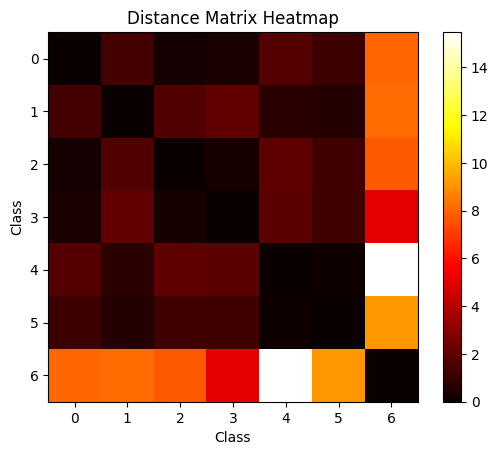

array([[ 0.        ,  1.35798804,  0.24356781,  0.37923996,  1.75070364,
         1.15559698,  8.02097049],
       [ 1.35798804,  0.        ,  1.666387  ,  2.00398734,  0.75244943,
         0.65515476,  8.11237075],
       [ 0.24356781,  1.666387  ,  0.        ,  0.3278962 ,  1.99105941,
         1.30654561,  7.70244182],
       [ 0.37923996,  2.00398734,  0.3278962 ,  0.        ,  1.88823945,
         1.25121282,  5.01901935],
       [ 1.75070364,  0.75244943,  1.99105941,  1.88823945,  0.        ,
         0.17962527, 15.4736105 ],
       [ 1.15559698,  0.65515476,  1.30654561,  1.25121282,  0.17962527,
         0.        ,  9.17604354],
       [ 8.02097049,  8.11237075,  7.70244182,  5.01901935, 15.4736105 ,
         9.17604354,  0.        ]])

In [28]:
distance_matrix_subset(distance_matrix_subset_0, [0, 1, 2, 5, 6, 7, 8])